In [55]:
# import and dataset loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings('ignore')

dataset = pd.read_csv("example_dataset.csv")

In [56]:
base_path="./"
def fasttextPreTrained(vecfile):
    """
    Creates a dictionary in which every character, bigram or trigram is associated with a numeric vector
    :param vecfile: str
        String representing path in which FastText vecfile is located
    :return: embeddings_index: dict
        Dictionary containing the vectorization of characters,bigrams or trigrams
        key: character,bigram or trigram
        value: numeric vector associated to key
    """
    ######################################
    # EMBEDDING LAYER
    #####################################
    embeddings_index = {}
    f = open(vecfile, "r")
    next(f)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [57]:
dim=3
dict_skipgram = fasttextPreTrained(f"{base_path}/fasttext.vec")
domain_names = dataset["bigrams"].to_numpy()
max_len = np.max([len(x.split()) for x in domain_names])
embedded_domain_names = []
for name in domain_names:
    sequences = np.array(
        [dict_skipgram.get(token) if dict_skipgram.get(token) is not None else np.zeros(dim)
         for token in name.split()], dtype=np.single)
    pad = np.zeros(dim * (max_len - len(name.split())), dtype=np.single)
    embedded_domain_name = np.concatenate((sequences, pad), axis=None, dtype=np.single)
    embedded_domain_names.append(embedded_domain_name)
embedded_domain_names_df = pd.DataFrame(embedded_domain_names)
print(embedded_domain_names_df)

Found 1330 word vectors.
           0         1         2         3         4         5         6     
0    -1.605471 -0.541829  0.454933 -1.379988 -0.788692  0.552011 -1.713197  \
1    -1.213661  0.009734  0.386734 -1.510524 -0.781731  0.542584 -1.334171   
2    -0.186788 -1.058991  1.166266 -0.571405 -1.136771  0.955850 -0.339861   
3    -0.546095 -1.176629  0.982990 -1.479382 -0.756001  0.544511 -1.299846   
4    -1.406574 -0.231876  0.401584 -1.345296 -0.212878  0.418042 -1.510738   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.478042  0.108911  1.802896 -1.270431  0.537538  0.375591 -1.237653   
9996 -0.436019  0.900982  0.707289 -0.471186  1.034299  0.715073 -0.573766   
9997 -0.501045  1.161803  0.704084 -0.351755  1.220803  0.862170 -0.981011   
9998  0.245739  0.393291  1.349615  0.505329  0.165129  1.882091  0.555169   
9999  0.194090  0.431672  1.269560  0.463730  0.216568  1.789202 -0.062246   

           7         8         9    ..

In [60]:
#Lettura dati ed embedding
families = set(dataset["label_multiclass"])
families.remove("legit")
family_dict = {family: i for i, family in enumerate(sorted(families), 1)}
family_dict.update({"legit": 0})
true_labels = [family_dict[family] for family in dataset["label_multiclass"].to_numpy()]
true_labels_df = pd.DataFrame({"labels_multiclass": pd.Series(true_labels)})
#random state per test con lo stesso split ogni volta
train, test, label_train, label_test=train_test_split(embedded_domain_names_df, true_labels_df, test_size=0.1, 
                                                      random_state=30)
print(train.shape)
print(test.shape)
print(label_train.shape)
print(label_test.shape)

(9000, 105)
(1000, 105)
(9000, 1)
(1000, 1)


In [61]:
# setting altri parametri per la classificazione
kfold = StratifiedKFold(n_splits=5)
cross_validation_scores = [] # punteggi della cross validation
classification_reports = []
confusion_matrices = []
roc_aucs = [] #roc curve:
true_pos_rates = []
false_pos_rates = []
#prep classificatori
names=["SVC", "KNN", "Naive Bayes", "Decision Tree", "Random Forest", "MLP", "Gradient Boosting", "AdaBoost"]
classifiers=[ SVC(), KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(),
              RandomForestClassifier(), MLPClassifier(batch_size=105), 
              GradientBoostingClassifier(), AdaBoostClassifier()]

In [62]:
#train e test dei classificatori:
for name, classif in zip(names,classifiers):
    # fitting model and make predictions
    classif.fit(train, label_train)
    predictions = classif.predict(test)
    print(f"{name}. Accuracy: {accuracy_score(label_test, predictions)}")
    # cross-validation
    cv_score = cross_val_score(classif, train, label_train, scoring = "accuracy",cv = kfold, n_jobs=8)
    cross_validation_scores.append(cv_score)
    print("Done K-Fold cross-validation")
     # confusion matrix
    cf = confusion_matrix(label_test, predictions)
    confusion_matrices.append(cf)
    print("Computed confusion matrix")
    # classification report
    class_report = classification_report(label_test, predictions)
    classification_reports.append(class_report)
    print("Done classification report")
    print()

SVC. Accuracy: 0.943
Done K-Fold cross-validation
Computed confusion matrix
Done classification report

KNN. Accuracy: 0.927
Done K-Fold cross-validation
Computed confusion matrix
Done classification report

Naive Bayes. Accuracy: 0.372
Done K-Fold cross-validation
Computed confusion matrix
Done classification report

Decision Tree. Accuracy: 0.919
Done K-Fold cross-validation
Computed confusion matrix
Done classification report

Random Forest. Accuracy: 0.951
Done K-Fold cross-validation
Computed confusion matrix
Done classification report

MLP. Accuracy: 0.954
Done K-Fold cross-validation
Computed confusion matrix
Done classification report

Gradient Boosting. Accuracy: 0.964
Done K-Fold cross-validation
Computed confusion matrix
Done classification report



TypeError: AdaBoostClassifier with algorithm='SAMME.R' requires that the weak learner supports the calculation of class probabilities with a predict_proba method.
Please change the base estimator or set algorithm='SAMME' instead.

   CrossValMeans  CrossValerrors          Algorithm
0       0.935889        0.001633                SVC
1       0.931222        0.004380                KNN
2       0.387778        0.003752        Naive Bayes
3       0.917000        0.001089      Decision Tree
4       0.945111        0.006511      Random Forest
5       0.666667        0.078131           AdaBoost
6       0.903778        0.005884  Gradient Boosting
7       0.945000        0.003002                MLP


Text(0.5, 1.0, 'Cross validation scores')

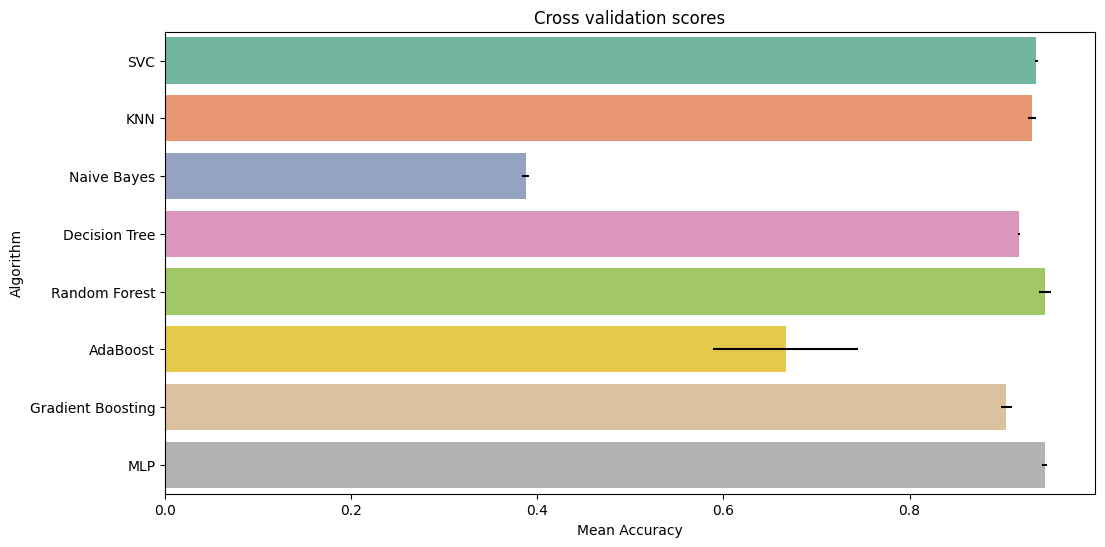

In [10]:
cross_val_mean_acc = [] # accuretezza media della cross validation
cross_val_std = [] # deviazione standard della cross validation
# cross validation plot
for i in cross_validation_scores:
    cross_val_mean_acc.append(i.mean())
    cross_val_std.append(i.std())
cv_df = pd.DataFrame({"CrossValMeans":cross_val_mean_acc, "CrossValerrors": cross_val_std,"Algorithm":names})
print(cv_df)
plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans",y="Algorithm", data=cv_df, palette="Set2",orient = "h", **{'xerr':cross_val_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

In [11]:
# normalizzazione matrici di confusione
confusion_matrices_2 = np.zeros(shape=np.array(confusion_matrices).shape)
for i in range(len(confusion_matrices)):
    for j in range(len(confusion_matrices[i])):
        tot = sum(confusion_matrices[i][j])
        for k in range(len(confusion_matrices[i][j])):
            confusion_matrices_2[i][j][k] = confusion_matrices[i][j][k]/tot

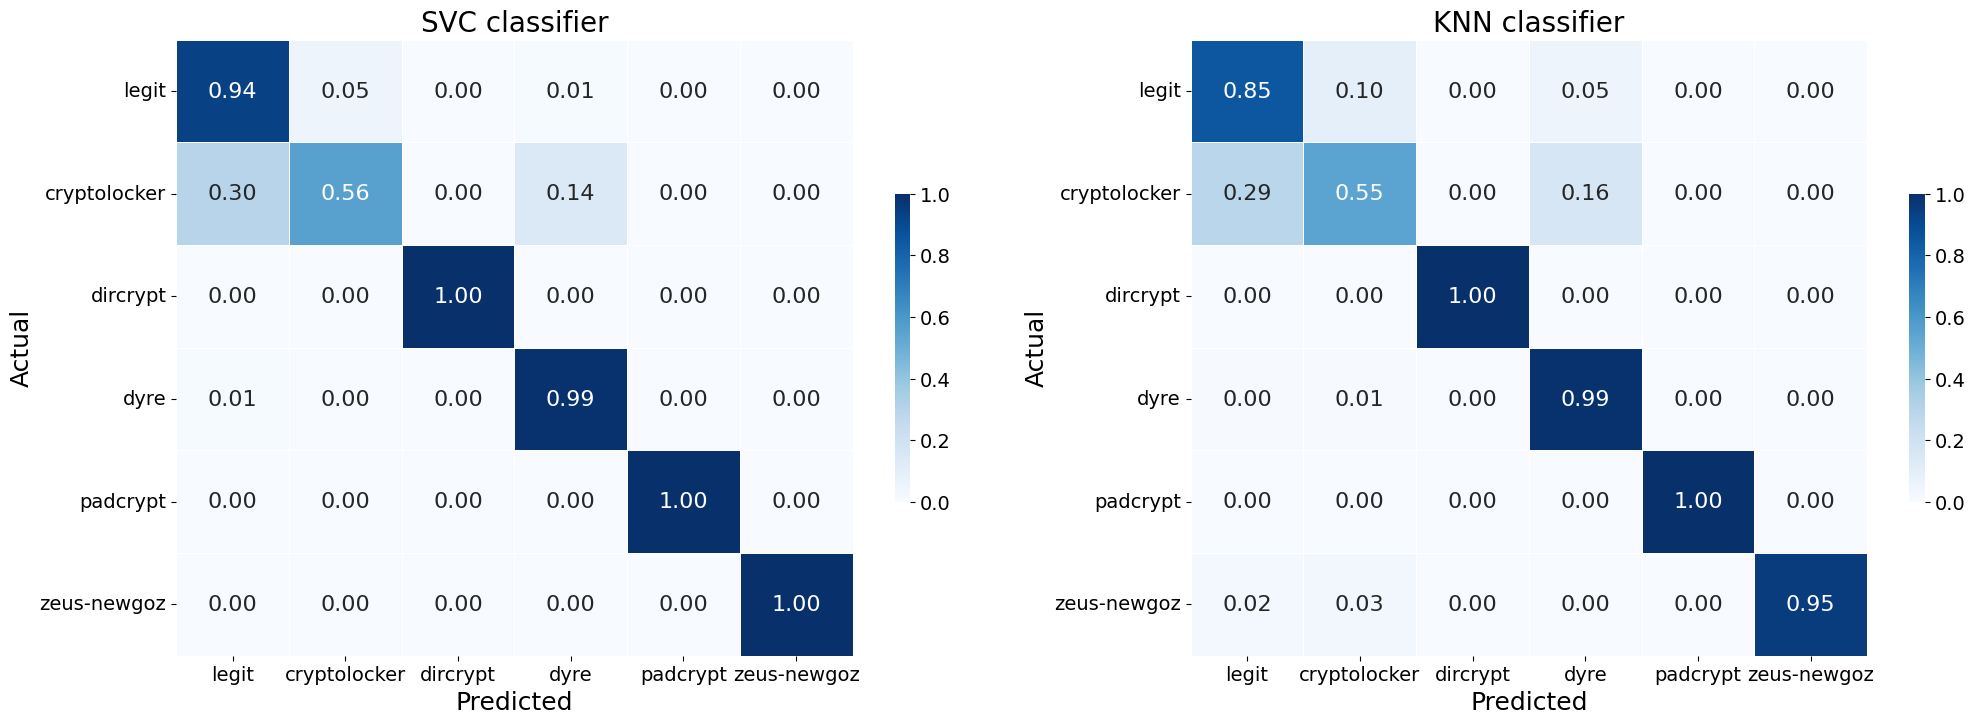

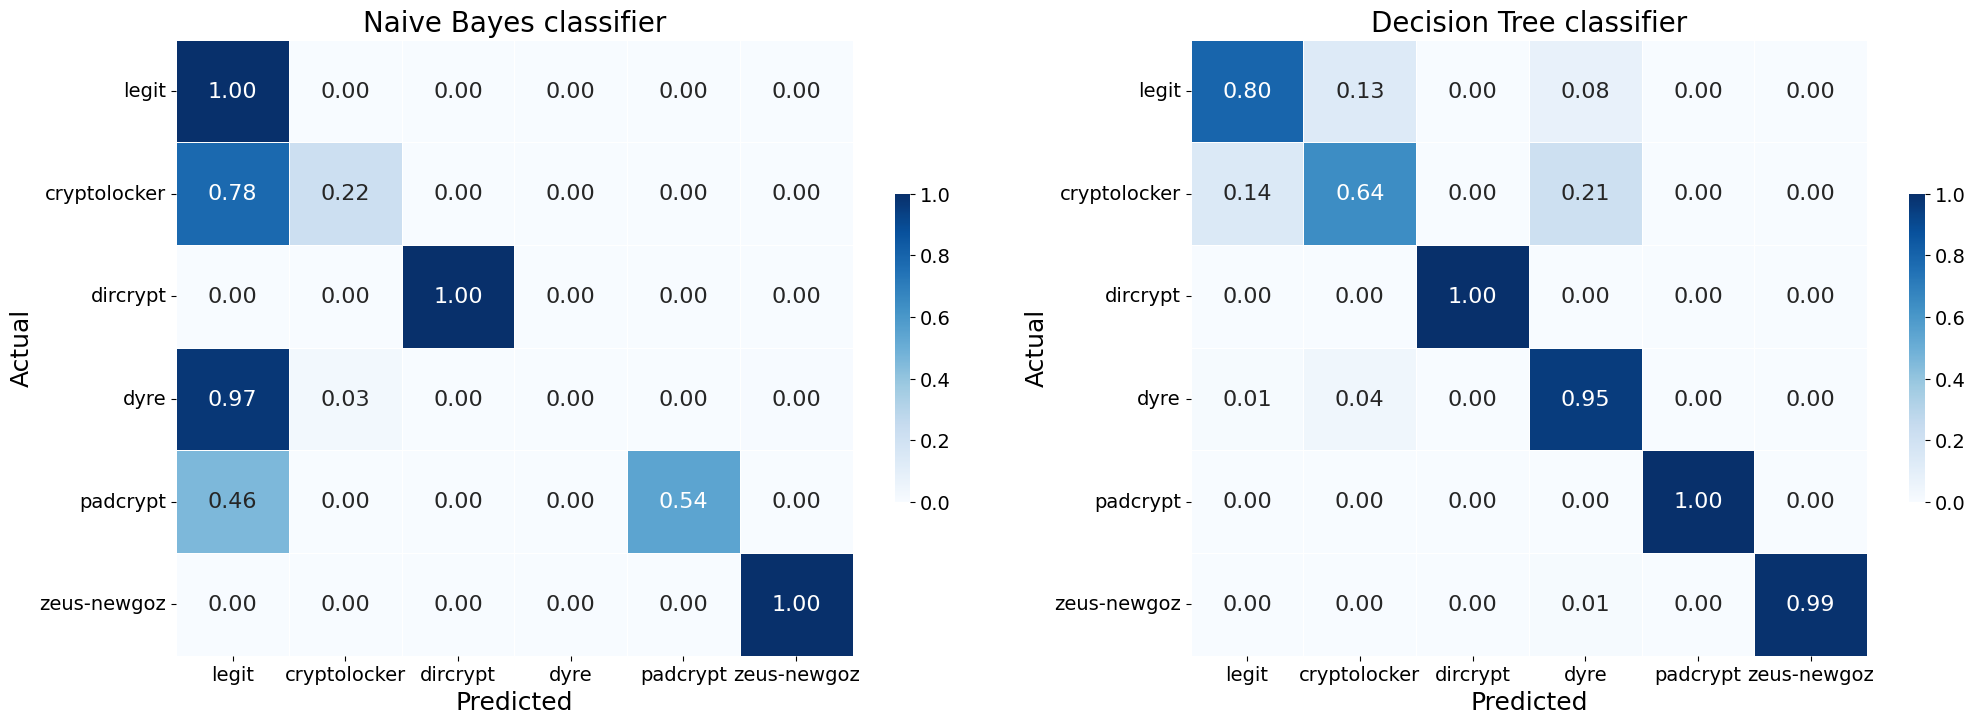

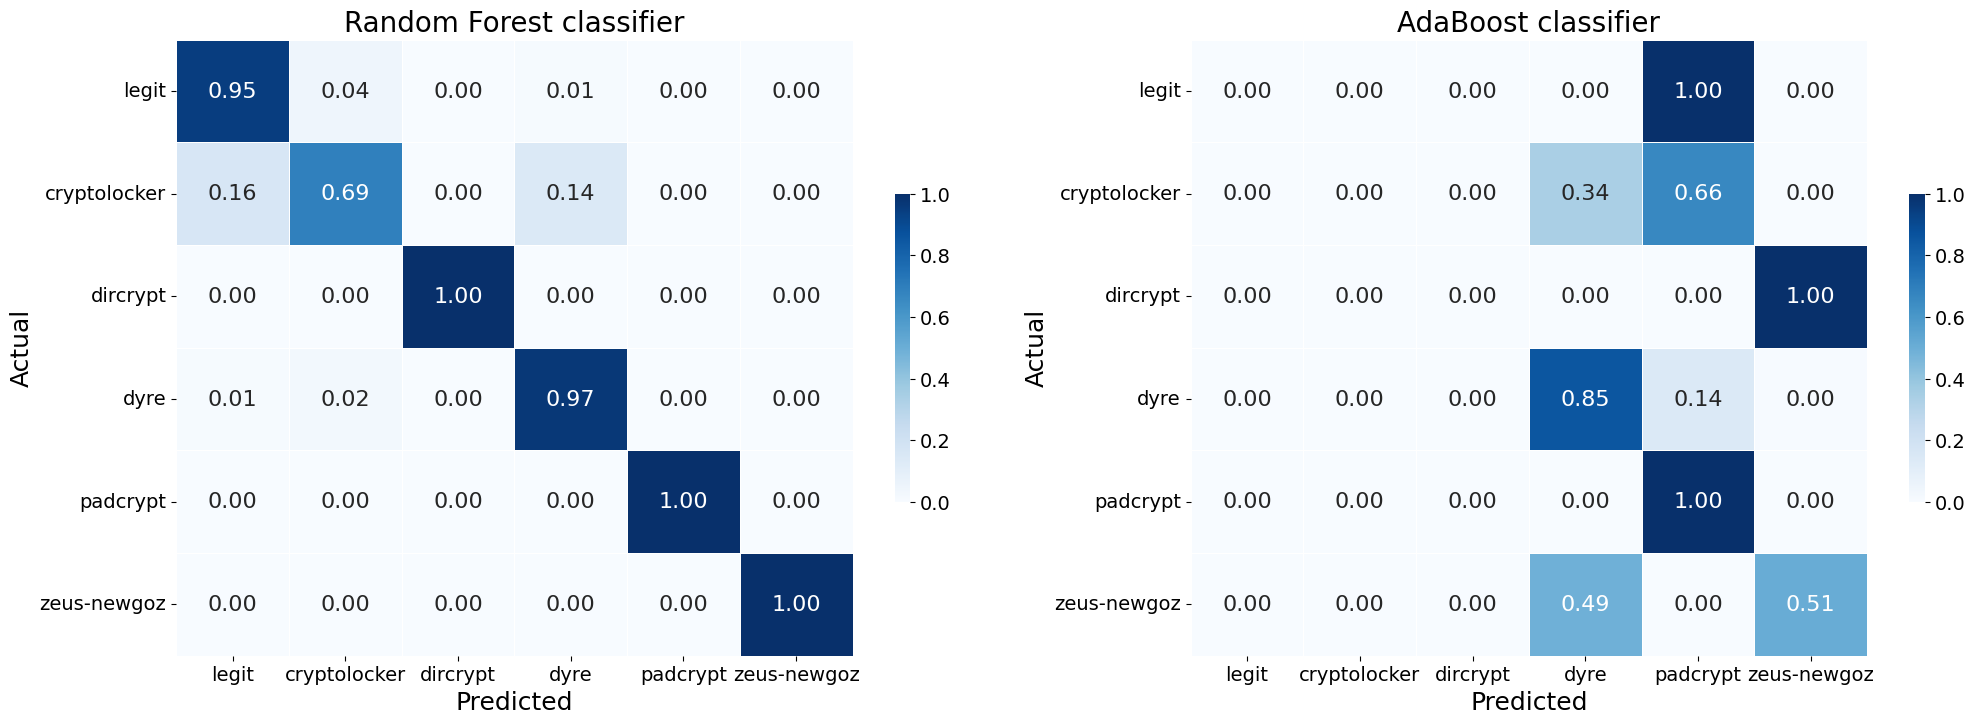

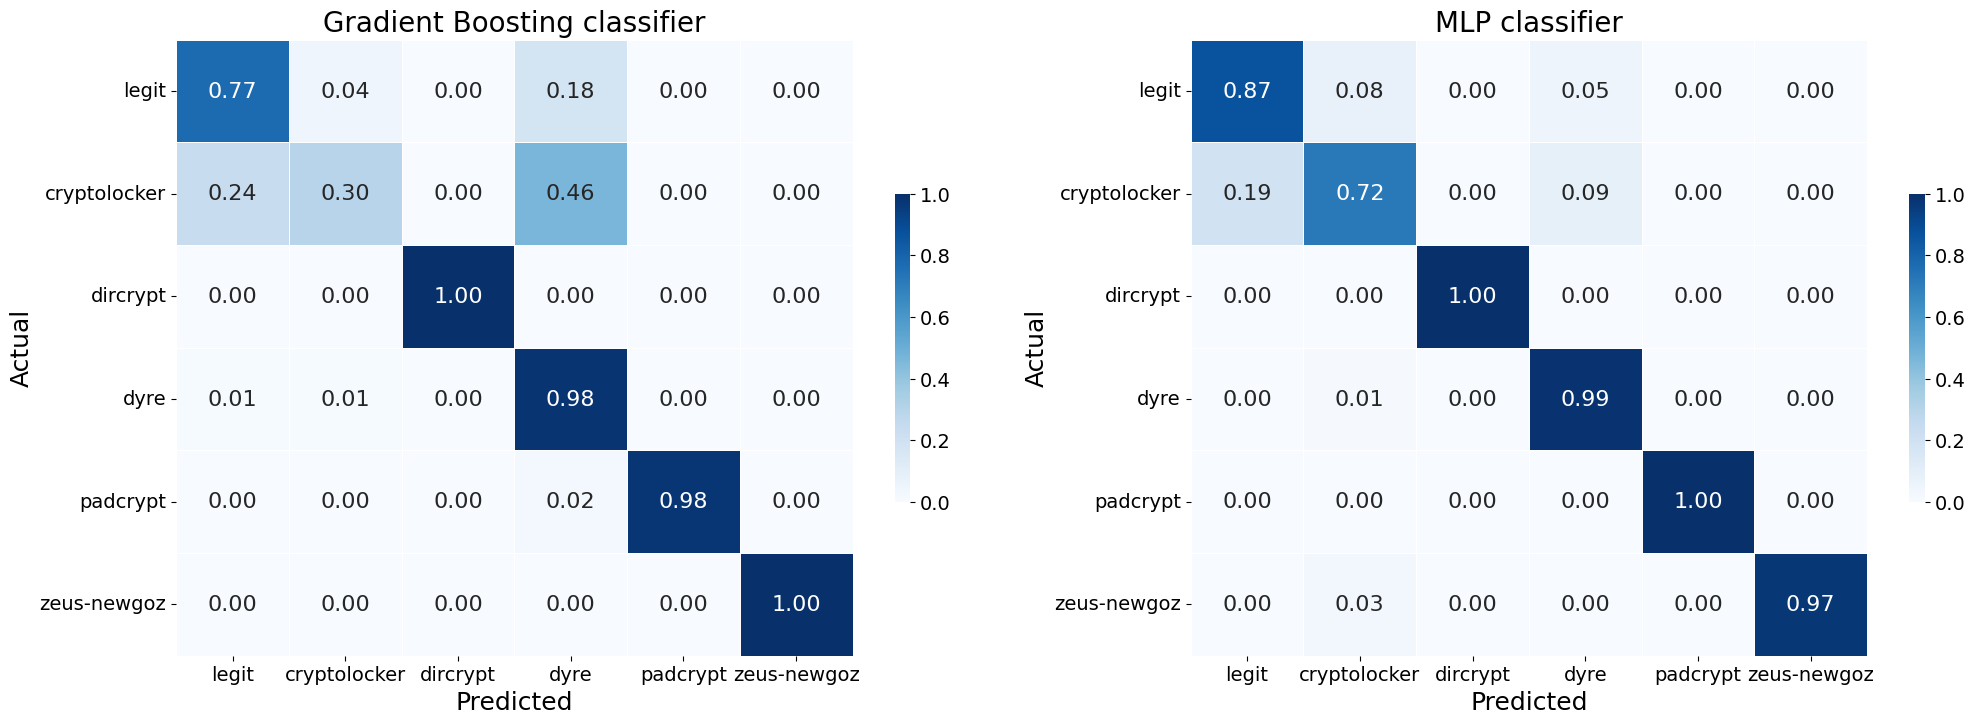

In [53]:
# Confusion matrixes (not-normalized confusion matrix)
tick_names = [list(filter(lambda x: family_dict[x] == i, family_dict))[0] for i in range(6)]
for i in range(len(names)):
    if i in [0,2,4,6]:
        figure, axes = plt.subplots(1,2)
        figure.set_size_inches(24, 8)
    sns.heatmap(confusion_matrices_2[i], annot=True, ax=axes[i%2], linewidths=.5, fmt=".2f", 
                cmap='Blues', annot_kws={"size": 16}, cbar_kws={"shrink": 0.5}, xticklabels=True, yticklabels=True)
    figure.axes[-1].yaxis.label.set_size(14)
    figure.axes[-1].tick_params(labelsize=14)
    axes[i%2].set_xticks(rotation=0, fontsize=14, ticks=[i+0.5 for i in range(6)], labels=tick_names)
    axes[i%2].set_yticks(rotation=0, fontsize=14, ticks=[i+0.5 for i in range(6)], labels=tick_names)
    axes[i%2].set_xlabel("Predicted", fontsize=18)
    axes[i%2].set_ylabel("Actual", fontsize=18)
    axes[i%2].set_title(f"{names[i]} classifier", fontsize=20)

In [51]:
#Classification reports
for i in range(len(names)):
    print (f"{names[i]} Classification Report:" );
    print (classification_reports[i]);

SVC Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.92      0.80        93
           2       0.87      0.51      0.64       104
           3       1.00      1.00      1.00       105
           4       0.96      0.98      0.97       506
           5       1.00      1.00      1.00        90
           6       1.00      1.00      1.00       102

    accuracy                           0.93      1000
   macro avg       0.92      0.90      0.90      1000
weighted avg       0.94      0.93      0.93      1000

KNN Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.85      0.76        93
           2       0.79      0.54      0.64       104
           3       1.00      1.00      1.00       105
           4       0.95      0.97      0.96       506
           5       0.98      1.00      0.99        90
           6       1.00      0.99      1.00       102

    accuracy           

In [ ]:
#max depth non saprei a che settarla, bisognerebbe vedere quale è la 
DT_param = {"max_depth": [2,3,8,10],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "criterion": ["gini", "entropy", "log_loss"]}

MLP_param = {"hidden_layer_sizes": [50, 100, 150],
             "learning_rate":["constant", "invscaling", "adapting"]
             "alpha": [0.0001,0.0004,0.0007,0.001],
             "solver": ["lbfgs", "sgd", "adam"],
             "activation": ["logistic", "identity", "tanh", "relu"]}

#using 4 n_jobs for faster processing
DTgs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, 
                    cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
MLPgs = GridSearchCV(MLPClassifier(), param_grid=GB_param, 
                     cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)

models = [DTgs, MLPgs]

gs_model = []
score = []
best_params=[]

for model in models:
    model.fit(train, label_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)
    best_params.append(model.best_params_)

print(f"Decision Tree best parameters: {best_params[0]}")
print(f"Decision Tree with grid search, best score: {score[0]}")
print(f"Decision Tree without grid search: {cv_acc[3]}")
print(f"Multi-Layer Perceptron best parameters: {best_params[1]}")
print(f"Multi-Layer Perceptron with grid search, best score: {score[1]}")
print(f"Multi-Layer Perceptron without grid search: {cv_acc[6]}")